In [66]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [67]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

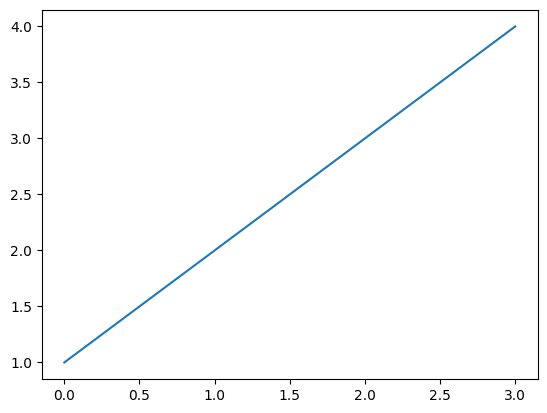

In [68]:
plt.plot([1,2,3,4])

In [69]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [70]:
pwd

'D:\\asy10\\FL_project\\mnist\\Client\\cli2'

In [73]:
# 클라이언트와의 접속 확인 
# 서버로부터 클로벌 모델 파일 명 recv 
# 서버로부터  모델 파일 recv
from socket import *
from os.path import exists
import sys
import os 

    

    
clientSock1 = socket(AF_INET, SOCK_STREAM)
clientSock1.connect(('127.0.0.1', 2266))

print('연결 성공! ')
#filename = '/server-global-eff-model.pth'
filename = 'global-update-2-mnist.pt'
clientSock1.sendall(filename.encode())

data = clientSock1.recv(4096)
data_transferred = 0

if not data:
    print('파일 %s가 서버에 존재 하지 않음' %filename)
    sys.exit()

save_dir = os.path.join('D:\\asy10\\FL_project\\mnist\\Client\\cli2\\model_file_cli2', filename)

print(save_dir)

with open(save_dir, 'wb') as f:
    try :
        while data:
            f.write(data)
            data_transferred += len(data)
            data = clientSock1.recv(4096)


    except Exception as ex:
        print(ex)
print("파일 %s 받기 완료 : 전송량 %d " %(filename, data_transferred))
clientSock1.close()
    
    

연결 성공! 
D:\asy10\FL_project\mnist\Client\cli2\model_file_cli2\global-update-2-mnist.pt
파일 global-update-2-mnist.pt 받기 완료 : 전송량 5912669 


In [74]:

batch_size = 64
learning_rate = 0.01
num_epochs = 30

In [75]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
train_data = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Download and load the test data
test_data = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [76]:
len(train_data)//2

30000

In [77]:
len(train_data)

60000

In [78]:
len(test_data)

10000

### 전체 train data 6만개 

In [79]:
import random

valid_size = 0.2
test_size = 0.1
num_train = len(train_data) # 50000개 중에서 25000개 랜덤 추출 

indices = list(range(num_train)) # 0 ~ 24999
sample_indices = random.sample(indices, num_train//2) # 50000개 중에서 25000개 랜덤 추출 
len(sample_indices)

split = int(np.floor(valid_size * (num_train//2))) # 0.2 * 10000
print(split)
train_idx, valid_idx = sample_indices[split:], sample_indices[:split] # train 20000, valid 5000 개씩 indices 리스트에서 랜덤한 인덱스 가져오기 
print(len(train_idx), len(valid_idx))

6000
24000 6000


In [80]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=64, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

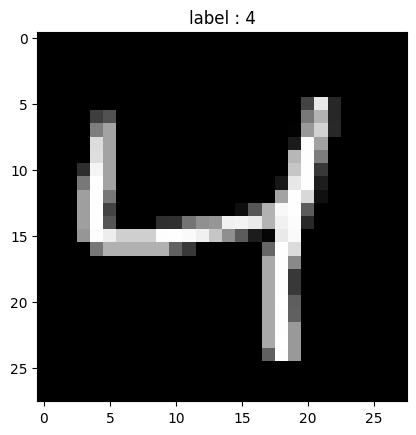

In [81]:
image, label = train_data[2]
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title('label : %s' % label)
plt.show()

In [82]:
first_batch = train_loader.__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name            | type                      | size
Num of Batch    |                           | 375
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([64, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([64])


In [83]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [84]:
device

device(type='cuda')

In [85]:
classes= [0,1,2,3,4,5,6,7,8,9]

### 서버로 부터 받은 글로벌 모델 파일 로드하기

In [86]:
pwd

'D:\\asy10\\FL_project\\mnist\\Client\\cli2'

In [88]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop(self.fc1(out))
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight) 


model = torch.load('./model_file_cli2/global-update-2-mnist.pt')

In [89]:
model.to(device)

Classifier(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [91]:
from tqdm import tqdm

In [93]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

for e in range(0, n_epochs):
   
    ###################
    # train the model #
    ###################
    model.train()
    gc.collect()
    torch.cuda.empty_cache()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape) # 모델의 출력과, 실제 정답 비교 
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)
    scheduler.step()
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        gc.collect()
        torch.cuda.empty_cache()
        for data, labels in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), './model_file_cli2/mnist-model_2-update-3.pt')
        valid_loss_min = valid_loss[e]

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 68.66it/s]


Epoch: 0 	Training Loss: 0.009821 	Validation Loss: 0.008334
Epoch: 0 	Training accuracy: 0.997625 	Validation accuracy: 0.998116
Validation loss decreased (inf --> 0.008334).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 74.37it/s]


Epoch: 1 	Training Loss: 0.009003 	Validation Loss: 0.008255
Epoch: 1 	Training accuracy: 0.998042 	Validation accuracy: 0.998172
Validation loss decreased (0.008334 --> 0.008255).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.09it/s]


Epoch: 2 	Training Loss: 0.008891 	Validation Loss: 0.008323
Epoch: 2 	Training accuracy: 0.998208 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.84it/s]


Epoch: 3 	Training Loss: 0.008574 	Validation Loss: 0.008567
Epoch: 3 	Training accuracy: 0.997958 	Validation accuracy: 0.998338


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.27it/s]


Epoch: 4 	Training Loss: 0.007811 	Validation Loss: 0.008511
Epoch: 4 	Training accuracy: 0.998292 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 69.66it/s]


Epoch: 5 	Training Loss: 0.007312 	Validation Loss: 0.008243
Epoch: 5 	Training accuracy: 0.998458 	Validation accuracy: 0.998338
Validation loss decreased (0.008255 --> 0.008243).  Saving model ...


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.32it/s]


Epoch: 6 	Training Loss: 0.007700 	Validation Loss: 0.008698
Epoch: 6 	Training accuracy: 0.998333 	Validation accuracy: 0.997673


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.21it/s]


Epoch: 7 	Training Loss: 0.007231 	Validation Loss: 0.008721
Epoch: 7 	Training accuracy: 0.998458 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 74.31it/s]


Epoch: 8 	Training Loss: 0.006621 	Validation Loss: 0.008484
Epoch: 8 	Training accuracy: 0.998792 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 74.95it/s]


Epoch: 9 	Training Loss: 0.006578 	Validation Loss: 0.009007
Epoch: 9 	Training accuracy: 0.998792 	Validation accuracy: 0.997673


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.96it/s]


Epoch: 10 	Training Loss: 0.006144 	Validation Loss: 0.008751
Epoch: 10 	Training accuracy: 0.998792 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 70.41it/s]


Epoch: 11 	Training Loss: 0.005584 	Validation Loss: 0.008693
Epoch: 11 	Training accuracy: 0.999083 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 72.25it/s]


Epoch: 12 	Training Loss: 0.005775 	Validation Loss: 0.008676
Epoch: 12 	Training accuracy: 0.998833 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.96it/s]


Epoch: 13 	Training Loss: 0.005778 	Validation Loss: 0.008668
Epoch: 13 	Training accuracy: 0.998958 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.49it/s]


Epoch: 14 	Training Loss: 0.005729 	Validation Loss: 0.008589
Epoch: 14 	Training accuracy: 0.998833 	Validation accuracy: 0.997839


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 74.19it/s]


Epoch: 15 	Training Loss: 0.005722 	Validation Loss: 0.008747
Epoch: 15 	Training accuracy: 0.998917 	Validation accuracy: 0.997784


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 74.54it/s]


Epoch: 16 	Training Loss: 0.005836 	Validation Loss: 0.008625
Epoch: 16 	Training accuracy: 0.999042 	Validation accuracy: 0.997839


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 72.87it/s]


Epoch: 17 	Training Loss: 0.005548 	Validation Loss: 0.008637
Epoch: 17 	Training accuracy: 0.999167 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 71.82it/s]


Epoch: 18 	Training Loss: 0.005818 	Validation Loss: 0.008706
Epoch: 18 	Training accuracy: 0.999250 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.44it/s]


Epoch: 19 	Training Loss: 0.005513 	Validation Loss: 0.008674
Epoch: 19 	Training accuracy: 0.998917 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.38it/s]


Epoch: 20 	Training Loss: 0.005823 	Validation Loss: 0.008608
Epoch: 20 	Training accuracy: 0.998917 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 72.14it/s]


Epoch: 21 	Training Loss: 0.005883 	Validation Loss: 0.008665
Epoch: 21 	Training accuracy: 0.999083 	Validation accuracy: 0.997839


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 73.21it/s]


Epoch: 22 	Training Loss: 0.005582 	Validation Loss: 0.008694
Epoch: 22 	Training accuracy: 0.999250 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 75.32it/s]


Epoch: 23 	Training Loss: 0.005751 	Validation Loss: 0.008737
Epoch: 23 	Training accuracy: 0.999083 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 76.11it/s]


Epoch: 24 	Training Loss: 0.005446 	Validation Loss: 0.008706
Epoch: 24 	Training accuracy: 0.999125 	Validation accuracy: 0.998172


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 65.24it/s]


Epoch: 25 	Training Loss: 0.005607 	Validation Loss: 0.008675
Epoch: 25 	Training accuracy: 0.999250 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 67.26it/s]


Epoch: 26 	Training Loss: 0.005611 	Validation Loss: 0.008787
Epoch: 26 	Training accuracy: 0.998917 	Validation accuracy: 0.997784


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 66.73it/s]


Epoch: 27 	Training Loss: 0.005653 	Validation Loss: 0.008707
Epoch: 27 	Training accuracy: 0.998792 	Validation accuracy: 0.997839


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 65.31it/s]


Epoch: 28 	Training Loss: 0.005561 	Validation Loss: 0.008607
Epoch: 28 	Training accuracy: 0.999083 	Validation accuracy: 0.998005


100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 65.96it/s]

Epoch: 29 	Training Loss: 0.005791 	Validation Loss: 0.008745
Epoch: 29 	Training accuracy: 0.998958 	Validation accuracy: 0.997839


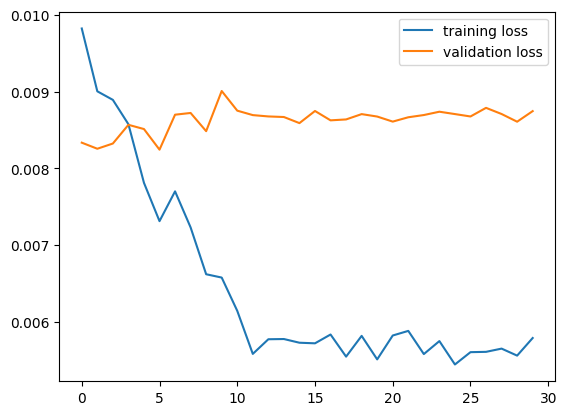

In [94]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

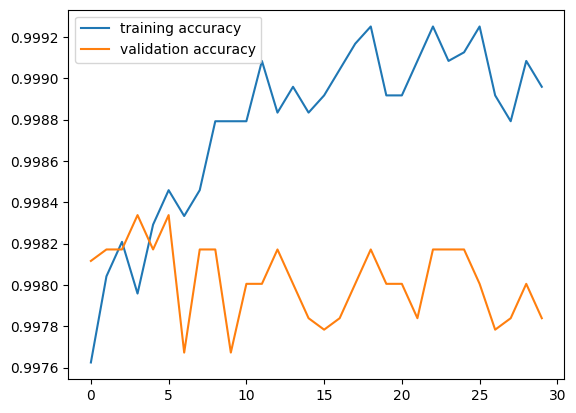

In [95]:
plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()

In [96]:
pwd

'D:\\asy10\\FL_project\\mnist\\Client\\cli2'

In [97]:
model.load_state_dict(torch.load( './model_file_cli2/mnist-model_2-update-3.pt'))

<All keys matched successfully>

In [98]:
# track test loss
test_loss = 0.0
test_acc = 0.0

class_correct = torch.zeros(100)
class_total = torch.zeros(100)

model.eval()
# iterate over test data
for data, labels in test_loader:
    # move tensors to GPU if CUDA is available
    data, labels = data.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    logits = model(data)
    # calculate the batch loss
    loss = criterion(logits, labels)
    # update test loss 
    test_loss += loss.item()
    
    ps = F.softmax(logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.reshape(top_class.shape)
    test_acc += torch.mean(equals.type(torch.float)).detach().cpu()
    
    for i in range(len(data)):
        label = labels[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader)
test_acc = test_acc/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Test Accuracy: {:.6f}\n'.format(test_acc))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            torch.sum(class_correct[i]), torch.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Loss: 0.024094

Test Accuracy: 0.991740

Test Accuracy of     0: 99% (976/980)
Test Accuracy of     1: 99% (1134/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 99% (1004/1010)
Test Accuracy of     4: 99% (974/982)
Test Accuracy of     5: 99% (885/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 99% (965/974)
Test Accuracy of     9: 98% (992/1009)


### Server로 모델 파라미터 파일 전송

In [99]:
# 서버랑 연결 접속 확인 
# client에서 server로 모델 파일 send

from socket import *
from os.path import exists
import sys

clientrSock1 = socket(AF_INET, SOCK_STREAM)
clientrSock1.connect(('127.0.0.1', 2266))

print('연결 성공! ')
filename = 'mnist-model_2-update-3.pt'
clientrSock1.sendall(filename.encode('utf-8')) ## 파일 이름 전송 


data_transferred = 0


print('파일 %s 전송시작 ! ' %filename)


with open("./model_file_cli2/"+filename, 'rb') as f:
    try :
        data = f.read(2048)
        while data:
            data_transferred += clientrSock1.send(data) # data 전송 
            data = f.read(2048) # 파일에서 2048만큼 읽어오고 
    except Exception as ex:
        print(ex)
print("전송완료 : %s 전송량 %d " %(filename, data_transferred))
clientrSock1.close()

연결 성공! 
파일 mnist-model_2-update-3.pt 전송시작 ! 
전송완료 : mnist-model_2-update-3.pt 전송량 5908787 
